## Market Analysis with Integrated Ultra-Supercritical Power Plant Model: Pricetaker Assumption

This notebook presents a market analysis considering the pricetaker assumption for the integrated system of ultra-supercritical power plant and molten salt thermal energy storage. The electricity prices, LMP (locational marginal prices) are assumed to be given and to not change for the horizon in consideration. The prices used in this study are either obtained from a synthetic database, i.e. RTS-GMLC.

Import all packages and libraries required.

In [1]:
from pyomo.environ import Param, Objective, Expression, SolverFactory, value
import numpy as np
from dispatches.models.fossil_case.ultra_supercritical_plant.storage.\
    multiperiod_integrated_storage_usc import create_multiperiod_usc_model

# For plots
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)
scaling_obj = 1
scaling_factor = 1


Get the LMP data from a database or define the list of prices.

In [2]:
# Select lmp source data and scaling factor according to that
use_rts_data = False
use_mod_rts_data = True
if use_rts_data:
    print('>>>>>> Using RTS lmp data')
    with open('rts_results_all_prices_base_case.npy', 'rb') as f:
        price = np.load(f)
elif use_mod_rts_data:
    price = [22.9684, 21.1168, 20.4, 20.419,
             20.419, 21.2877, 23.07, 25,
             18.4634, 0, 0, 0,
             0, 0, 0, 0,
             19.0342, 23.07, 200, 200,
             200, 200, 200, 200]
else:
    print('>>>>>> Using NREL lmp data')
    price = np.load("nrel_scenario_average_hourly.npy")

if use_rts_data:
    lmp = price[0:number_hours].tolist()
elif use_mod_rts_data:
    lmp = price


Define the time horizon and period for the market analysis using the pricetaker assumption. A time-indexed multiperiod model is then constructed using the multiperiod method for the integrated ultra-supercritical power plant. Using the LMP data obtained above the electricity prices are assigned for each time period. Finally, the entire multi-period model is solved with an objective of maximizing the profit.

In [3]:
# Add number of days and hours per week
ndays = 1
nweeks = 1
number_hours = 24 * ndays
n_time_points = nweeks * number_hours

# Add status for storage tanks
tank_status = "hot_empty"
tank_min = 1  # in kg 92006046.67
tank_max = 6739292  # in kg

# Create the multiperiod model object. You can pass arguments to your
# "process_model_func" for each time period using a dict of dicts as
# shown here.  In this case, it is setting up empty dictionaries for
# each time period.
multiperiod_usc = create_multiperiod_usc_model(
    n_time_points=n_time_points, pmin=None, pmax=None
)

# Retrieve pyomo model and active process blocks (i.e. time blocks)
m = multiperiod_usc.pyomo_model
blks = multiperiod_usc.get_active_process_blocks()

# Add lmp market data for each block
count = 0
for blk in blks:
    blk_usc_mp = blk.usc_mp
    blk.lmp_signal = Param(default=0, mutable=True)
    blk.revenue = lmp[count]*blk.usc_mp.fs.net_power * scaling_factor
    blk.operating_cost = Expression(
        expr=(
            (blk_usc_mp.fs.operating_cost
             + blk_usc_mp.fs.plant_fixed_operating_cost
             + blk_usc_mp.fs.plant_variable_operating_cost) / (365 * 24)
        ) * scaling_factor
    )
    blk.cost = Expression(expr=-(blk.revenue - blk.operating_cost))
    count += 1

m.obj = Objective(expr=sum([blk.cost for blk in blks]) * scaling_obj)

# Initial state for salt tank for different scenarios
# Tank initial scenarios:"hot_empty","hot_full","hot_half_full"
if tank_status == "hot_empty":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(1103053.48)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_max-1103053.48)
elif tank_status == "half_full":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(tank_max/2)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_max/2)
elif tank_status == "hot_full":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(tank_max-tank_min)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_min)
else:
    print("Unrecognized scenario! Try hot_empty, hot_full, or half_full")

blks[0].usc_mp.previous_power.fix(447.66)

# Plot results
opt = SolverFactory('ipopt')
hot_tank_level = []
cold_tank_level = []
net_power = []
hxc_duty = []
hxd_duty = []
for week in range(nweeks):
    print()
    print(">>>>>> Solving for week {}: {} hours of operation in {} day(s) "
          .format(week + 1, number_hours, ndays))

    opt.solve(m, tee=True)

    hot_tank_level.append(
        [(value(blks[i].usc_mp.salt_inventory_hot) / scaling_factor)*1e-3
         for i in range(n_time_points)])
    cold_tank_level.append(
        [(value(blks[i].usc_mp.salt_inventory_cold) / scaling_factor)*1e-3
         for i in range(n_time_points)])
    net_power.append(
        [value(blks[i].usc_mp.fs.net_power)
         for i in range(n_time_points)])
    hxc_duty.append(
        [value(blks[i].usc_mp.fs.hxc.heat_duty[0])*1e-6
         for i in range(n_time_points)])
    hxd_duty.append(
        [value(blks[i].usc_mp.fs.hxd.heat_duty[0])*1e-6
         for i in range(n_time_points)])


>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time

  52 -4.5445457e+05 1.71e+07 4.39e+03  -1.0 5.47e+05  -4.0 5.10e-02 2.43e-02h  1
  53 -4.5445455e+05 1.71e+07 4.39e+03  -1.0 5.33e+05  -4.5 9.39e-02 2.48e-04h  1
  54 -4.5445454e+05 1.71e+07 3.72e+06  -1.0 5.34e+05  -5.0 1.59e-01 1.26e-04h  1
  55 -4.5445357e+05 1.68e+07 4.37e+06  -1.0 5.34e+05  -5.4 1.85e-01 1.54e-02h  1
  56 -4.5445344e+05 1.68e+07 4.15e+06  -1.0 7.32e+05  -5.9 1.25e-01 1.78e-03h  1
  57 -4.5445206e+05 1.65e+07 2.61e+06  -1.0 8.03e+05  -6.4 4.56e-01 1.90e-02h  1
  58 -4.5444856e+05 1.58e+07 2.37e+06  -1.0 9.20e+05  -6.9 9.81e-02 4.41e-02h  1
  59 -4.5444519e+05 1.52e+07 1.64e+06  -1.0 8.91e+05  -7.3 3.03e-01 3.65e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -4.5442447e+05 1.17e+07 1.32e+06  -1.0 8.68e+05  -7.8 1.97e-01 2.28e-01h  1
  61 -4.5441068e+05 9.29e+06 2.02e+04  -1.0 7.25e+05  -8.3 9.23e-01 2.07e-01h  1
  62 -4.5439602e+05 5.52e+06 5.93e+04  -1.0 6.05e+05  -8.8 1.00e+00 4.05e-01h  1
  63 -4.5440024e+05 3.55e+06

### Result analysis

#### Figure 1: Plotting the salt levels in the storage tank for the entire horizon

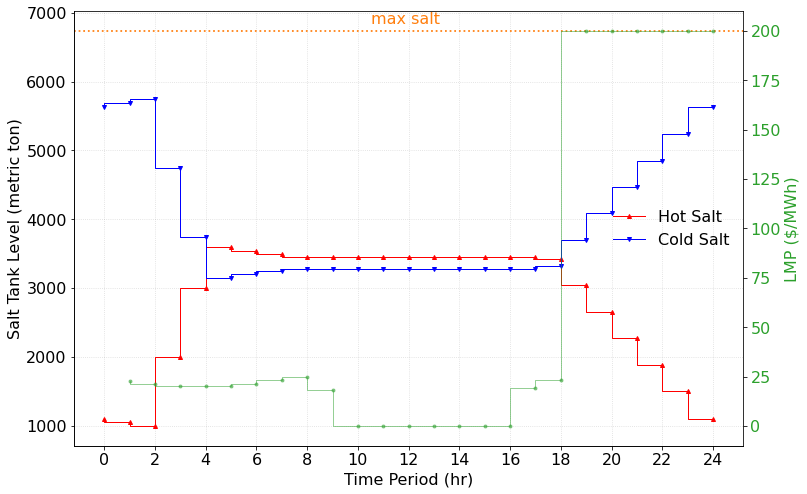

In [4]:
# Plot 1: Salt Tank Levels
max_power = 436  # in MW
max_power_storage = 30  # in MW
max_power_total = max_power + max_power_storage
min_storage_heat_duty = 10  # in MW
max_storage_heat_duty = 200  # in MW

n_time_points = 24 * ndays
hours = np.arange(n_time_points * nweeks)
lmp_array = np.asarray(lmp[0:n_time_points])
hot_tank_array = np.asarray(hot_tank_level[0:nweeks]).flatten()
cold_tank_array = np.asarray(cold_tank_level[0:nweeks]).flatten()

# Convert array to list to include hot tank level at time zero
hot_tank_array0 = (value(blks[0].usc_mp.previous_salt_inventory_hot) /
                   scaling_factor) * 1e-3
cold_tank_array0 = (value(blks[0].usc_mp.previous_salt_inventory_cold) /
                    scaling_factor) * 1e-3
hours_list = hours.tolist() + [n_time_points]
hot_tank_list = [hot_tank_array0] + hot_tank_array.tolist()
cold_tank_list = [cold_tank_array0] + cold_tank_array.tolist()

font = {'size': 16}
plt.rc('font', **font)
fig1, ax1 = plt.subplots(figsize=(12, 8))

color = ['r', 'b', 'tab:green', 'k', 'tab:orange']
ax1.set_xlabel('Time Period (hr)')
ax1.set_ylabel('Salt Tank Level (metric ton)',
               color=color[3])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.axhline((tank_max / scaling_factor)*1e-3, ls=':', lw=1.75,
            color=color[4])
plt.text(n_time_points / 2 - 1.5,
         (tank_max / scaling_factor) * 1e-3 + 100, 'max salt',
         color=color[4])
ax1.step(  # [x + 1 for x in hours], hot_tank_array,
    hours_list, hot_tank_list,
    marker='^', ms=4, label='Hot Salt',
    lw=1, color=color[0])
ax1.step(  # [x + 1 for x in hours], hot_tank_array,
    hours_list, cold_tank_list,
    marker='v', ms=4, label='Cold Salt',
    lw=1, color=color[1])
ax1.legend(loc="center right", frameon=False)
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(0, n_time_points*nweeks + 1, step=2))

ax2 = ax1.twinx()
ax2.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax2.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3, alpha=0.5,
         ls='-', lw=1,
         color=color[2])
ax2.tick_params(axis='y',
                labelcolor=color[2])


#### Figure 2: Plotting the power plant's operating profile in terms of total power for the entire horizon

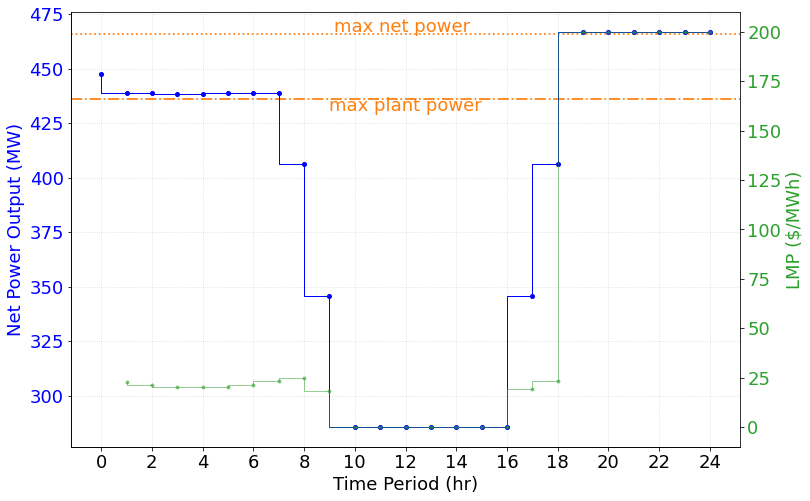

In [5]:
# Plant Power Production Profile
font = {'size': 18}
plt.rc('font', **font)

power_array = np.asarray(net_power[0:nweeks]).flatten()
# Convert array to list to include net power at time zero
power_array0 = value(blks[0].usc_mp.previous_power)
power_list = [power_array0] + power_array.tolist()

fig2, ax3 = plt.subplots(figsize=(12, 8))
ax3.set_xlabel('Time Period (hr)')
ax3.set_ylabel('Net Power Output (MW)',
               color=color[1])
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.text(n_time_points / 2 - 3, max_power - 5.5, 'max plant power',
         color=color[4])
plt.text(n_time_points / 2 - 2.8, max_power_total + 1, 'max net power',
         color=color[4])
plt.axhline(max_power, ls='-.', lw=1.75,
            color=color[4])
plt.axhline(max_power_total, ls=':', lw=1.75,
            color=color[4])
ax3.step(hours_list, power_list,
         marker='o', ms=4,
         lw=1, color=color[1])
ax3.tick_params(axis='y',
                labelcolor=color[1])
ax3.set_xticks(np.arange(0, n_time_points * nweeks + 1, step=2))

ax4 = ax3.twinx()
ax4.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax4.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3, alpha=0.5,
         ls='-', lw=1,
         color=color[2])
ax4.tick_params(axis='y',
                labelcolor=color[2])


#### Figure 3: Plotting the storage heat exchanger operating profiles in terms of heat duties for the entire horizon

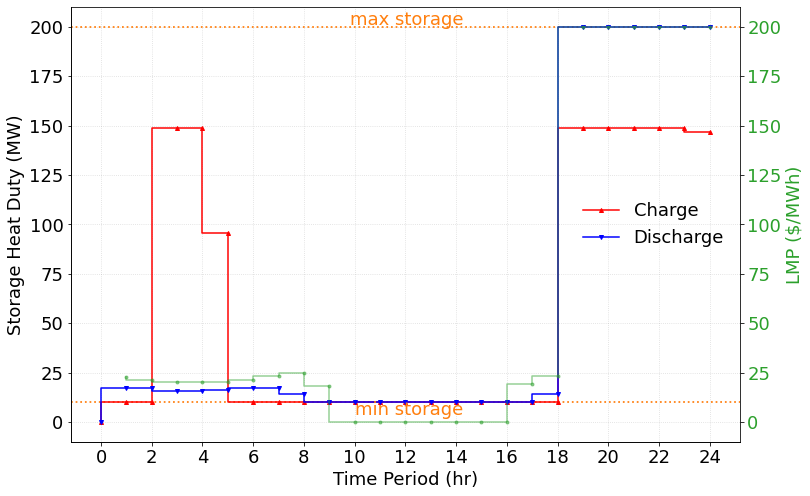

In [6]:
# Plot 3: Heat Exchanger Operation Profile
zero_point = True
hxc_array = np.asarray(hxc_duty[0:nweeks]).flatten()
hxd_array = np.asarray(hxd_duty[0:nweeks]).flatten()
hxc_duty0 = 0  # zero since the plant is not operating
hxc_duty_list = [hxc_duty0] + hxc_array.tolist()
hxd_duty0 = 0  # zero since the plant is not operating
hxd_duty_list = [hxd_duty0] + hxd_array.tolist()

fig3, ax5 = plt.subplots(figsize=(12, 8))
ax5.set_xlabel('Time Period (hr)')
ax5.set_ylabel('Storage Heat Duty (MW)',
               color=color[3])
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.text(n_time_points / 2 - 2.2, max_storage_heat_duty + 1, 'max storage',
         color=color[4])
plt.text(n_time_points / 2 - 2, min_storage_heat_duty - 6.5, 'min storage',
         color=color[4])
plt.axhline(max_storage_heat_duty, ls=':', lw=1.75,
            color=color[4])
plt.axhline(min_storage_heat_duty, ls=':', lw=1.75,
            color=color[4])
if zero_point:
    ax5.step(hours_list, hxc_duty_list,
             marker='^', ms=4, label='Charge',
             color=color[0])
    ax5.step(hours_list, hxd_duty_list,
             marker='v', ms=4, label='Discharge',
             color=color[1])
else:
    ax5.step([x + 1 for x in hours], hxc_array,
             marker='^', ms=4, lw=1,
             label='Charge',
             color=color[0])
    ax5.step([x + 1 for x in hours], hxd_array,
             marker='v', ms=4, lw=1,
             label='Discharge',
             color=color[1])
ax5.legend(loc="center right", frameon=False)
ax5.tick_params(axis='y',
                labelcolor=color[3])
ax5.set_xticks(np.arange(0, n_time_points * nweeks + 1, step=2))

ax6 = ax5.twinx()
ax6.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax6.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3, alpha=0.5,
         ls='-', color=color[2])
ax6.tick_params(axis='y',
                labelcolor=color[2])